## Synopsis

Gravitational wave detection has been a challenge for the scientists for a while: predicted with the general relativity theory back in 1916, no confirmed observations happened until 2015, nigh a century later. With gravity being the weakest known fundamental force, it requires pretty high masses just to show itself, and quick changes of mass on a large scale are extremely rare - the signals we study here originate from *black holes merging* events.

This dataset is synthetic, however its data still originates from 3 existing gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). The parameters that determine the exact form of a binary black hole waveform are the masses, sky location, distance, black hole spins, binary orientation angle, gravitational wave polarisation, time of arrival, and phase at coalescence (merger). These parameters (15 in total) have been randomised according to astrophysically motivated prior distributions and used to generate the simulated signals present in the data. Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. The task is to identify when a signal is present in the data (target=1).

## Approaching target

First of all, the amount of data is huge. There's 560k entries in the labeled train set, each sample containing 3 time series (1 for each detector) in a separate .npy file. Each observation spans 2 sec and is sampled at 2048 Hz.

This amounts to about 30 GB of clean data even at single precision, which makes fitting the whole set into memory of a consumer grade PC undesirable. That just screams implementing a proper Torch Dataset.

Signal processing is not so different from image processing, with the exception of the data being 1D. Convolutional networks do indeed work, with some adjustments we'll cover later. With some tweaks, you can even use classic 2D image processing nets, yet 1D is considered the way to go.

In [1]:
import pandas as pd

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset

from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import ProgressBar, Checkpoint, LRScheduler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

from os import walk
from multiprocessing import Pool

In [2]:
RANDOM_STATE = 177013
torch.manual_seed(RANDOM_STATE);

For the purpose of this notebook, we'll be using a small (1/256) fraction of the train set to monitor our learning progress.

In [3]:
train_dir = '/media/data/g2net-gravitational-wave-detection/train/'
valid_dir = '/media/data/g2net-gravitational-wave-detection/valid/'

We'll make a hashtable out of labels for faster lookups (surprisingly enough, pandas lookups are rather slow):

In [4]:
labels = dict(pd.read_csv('/media/data/g2net-gravitational-wave-detection/training_labels.csv').values)

## Filtering

Following the image processing analogy, our 'image' is really noisy - models won't even start learning until we filter it. The choice of the exact filter design is rather free, the main requirement is to get rid of very low frequencies. This is the basic implementation:

In [5]:
class BandPassFilter:
    def __init__(self, lf=30, hf=400, order=16, sr=2048):
        self.sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
        self.normalization = np.sqrt((hf - lf) / (sr / 2))
        # Tapered cosine window does little in our case, but YMMV.
        # self.window = signal.tukey(4096, 0.1)
    def __call__(self, wave):
        # wave *= self.window
        for i in range(3):
            wave[i] = signal.sosfilt(self.sos, wave[i]) * self.normalization
        return wave

In [6]:
bandpass = BandPassFilter()

Bandwidth selected roughly matches **compact binary inspirals** on the chart below (created by Christopher Moore, Robert Cole and Christopher Berry in 2013). Frequencies may be fine-tuned to improve the model performance.

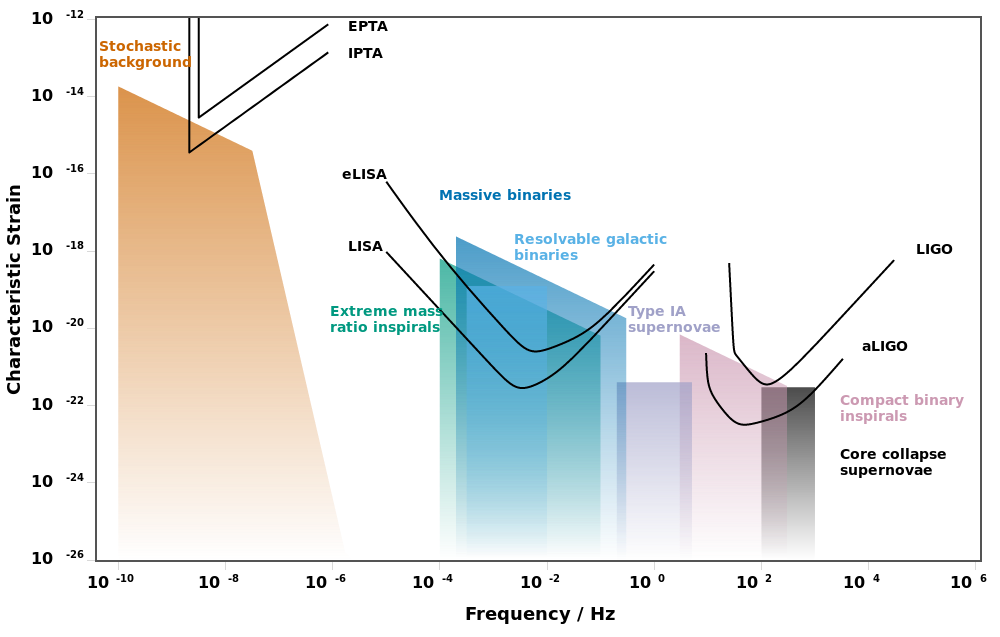

## Normalizing

Quantile transformation, sadly, would require unrealistic amount of computational time, however according to other participants there's no difference in the outcome between standard scaling and simply dividing by maximum observed value. This should be expected, as the measurements of the same intrument obviously belong to the same scale. In fact, normalizing by the max value even performs slightly better in our case.

In [7]:
def normalize(wave):
    for i in range(3):
        # Value reported by other participants:
        wave[i] = wave[i] / 4.6152116213830774e-20
    return wave

## Augmentation

Curiously enough, in most cases mixing vanilla and augmented data resulted in a negative impact over model accuracy. Thus we'll be training separate models on augmented and non-augmented sets and blending their results together.

### What was, shall be

Two LIGO detectors are of the same type and reportedly have identical parameters. As a first experiment, we'll be swapping them:

In [8]:
def swap(wave):
    wave[[0,1]] = wave[[1,0]]
    return wave

### What shall be, was

As a second experiment, we'll apply a small random time shift:

In [9]:
def shift(wave):
    for i in range(3):
        w_diff = np.random.randint(low=-10, high=11)
        wave[i] = np.roll(wave[i], w_diff)
    return wave

## Implementing the dataset

In [10]:
class NPYHotSwap(torch.utils.data.Dataset):
    '''
    Dynamically loads NPY files from every subdir.
    '''
    @staticmethod
    def process_file(file):
        '''
        Extracts the observation id from filename.
        '''
        observation_id = file[:-4]
        return observation_id

    def __init__(self, folder, labels, layers=3, shift=False, swap=False):
        '''
        Accepts the root folder and labels dict, the amount of hierarchy levels (default: 3)
        and whether to use augmentations.
        '''
        self.root = folder
        self.files = []
        self.layers = layers
        self.shift = shift
        self.swap = swap
        # Walk through the hierarchy and build a list of files:
        pool = Pool(12)
        for subdir, dirs, files in walk(self.root):
            results = pool.map(NPYHotSwap.process_file, files)
            if results:
                self.files.extend(results)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        path = (self.root + file[0] + '/' + file[1] + '/' + file[2] + '/' + file + '.npy' if self.layers == 3
                    else self.root + file[1] + '/' + file[2] + '/' + file + '.npy')
        # Load file:
        chunk = np.load(path).astype('float32')
        # Apply augmentations:
        if self.shift:
            chunk = shift(chunk)
        if self.swap:
            chunk = swap(chunk)
        # Normalize:
        chunk = normalize(chunk)
        # Filter:
        chunk = bandpass(chunk)

        return torch.from_numpy(chunk), torch.from_numpy(np.array(labels[file]).astype('long')) if file in labels else np.nan

In [11]:
# Vanilla train set:
train_set = NPYHotSwap(train_dir, labels)

In [12]:
# Augmented train set:
aug_set = NPYHotSwap(train_dir, labels, shift=True)

In [13]:
# Augmented train set #2:
swp_set = NPYHotSwap(train_dir, labels, swap=True)

In [14]:
# Small validation set:
valid_set = NPYHotSwap(valid_dir, labels, layers=2)

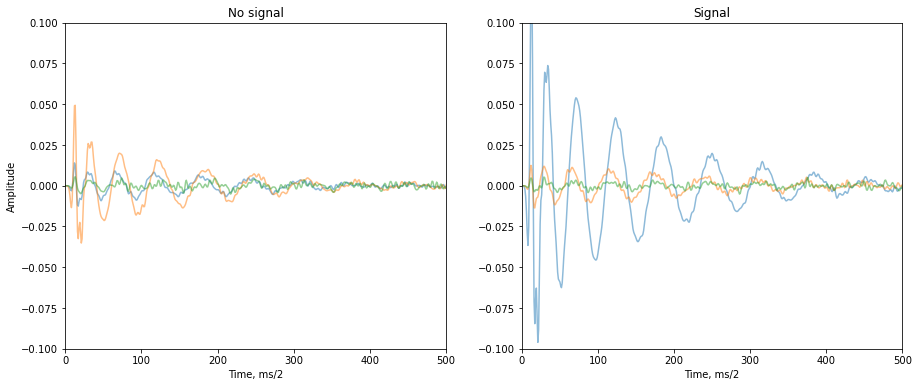

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(train_set[3][0][0], alpha=0.5);
axes[0].plot(train_set[3][0][1], alpha=0.5);
axes[0].plot(train_set[3][0][2], alpha=0.5);
axes[1].plot(train_set[4][0][0], alpha=0.5);
axes[1].plot(train_set[4][0][1], alpha=0.5);
axes[1].plot(train_set[4][0][2], alpha=0.5);
axes[0].set(xlim=(0, 500), ylim=(-0.1,0.1), title='No signal', xlabel='Time, ms/2', ylabel='Amplitude');
axes[1].set(xlim=(0, 500), ylim=(-0.1,0.1), title='Signal', xlabel='Time, ms/2');

As we can see, the difference between positive and negative classes is not so obvious: the dataset docs state that in most cases, signals are not visible by eye in the time series. Yet, the combination of shape and amplitude compared between different detectors after filtering seems to be the key.

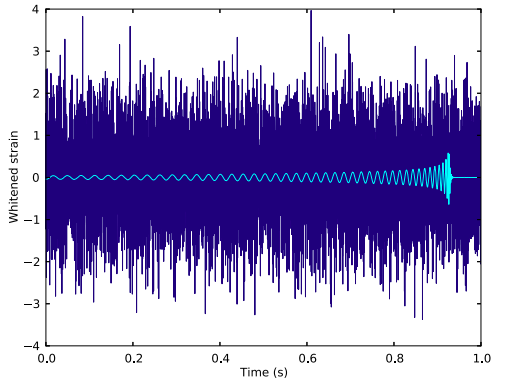

Noisy vs filtered signal from *Matching Matched Filtering with Deep Networks for Gravitational-Wave Astronomy* by Hunter Gabbard, Michael Williams, Fergus Hayes, and Chris Messenger (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103).

## Deep Dark Learning

We'll be using a simple half-UNET layer structure which served us well for many applications.

The key differences between image and signal classification, apart from the filtering part, would be:

- all convolutions are 1D, obviously; we can conveniently treat the three separate detectors as channels;
- kernels should be bigger than the image processing ones - 32 or 64 as a 'rule of thumb' starting value;
- we want our net to be reasonably fast so we won't be too greedy with internal channels amount;
- stride/padding adjustments make little to no difference;
- however, average pooling is better (and much faster) than max pooling;
- also, max pooling is rather indifferent to additional intermediate layers, while average pooling does benefit from an extra linear or LSTM;
- SiLU might be better than ReLU but YMMV.

As of the similarities, enabling `torch.backends.cudnn.benchmark` and disabling bias for Conv-BatchNorm combos still gives a significant (over 2x) speed boost.

The train set is well balanced with 50:50 class representation, so accuracy is a decent quality metric. Our target however will be ROC-AUC, which tends to be slightly higher than accuracy. Looking a bit ahead, over 80% accuracy is a good result.

The competition is tight, with the top solutions following very closely around 88% ROC-AUC, thus scoring over 85 can be considered an acceptable result. Using special learning schedulers like `CosineAnnealingLR` might be useful to squeeze as much as possible out of the learning rate.

Overall, proper filtering jumpstarts the accuracy from constant level to 70ish% area, bigger kernels bring it to 75+%. Any other tweaks' benefit does not seem to exceed a singular percent.

In [16]:
torch.backends.cudnn.benchmark = True

In [17]:
class Conv2Linear(nn.Module):
    def __init__(self, in_channels, out_channels, num_features):
        super(Conv2Linear, self).__init__()
        self.conv1 = self.contract_block(in_channels, num_features, 64, 2)
        self.conv2 = self.contract_block(num_features, num_features * 2, 32, 2)
        self.conv3 = self.contract_block(num_features * 2, num_features * 4, 32, 2)
        self.conv4 = self.contract_block(num_features * 4, num_features * 8, 16, 2)
        self.conv5 = self.contract_block(num_features * 8, num_features * 16, 16, 2)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(p=0.25)        
        self.linear = nn.Linear(num_features * 48, 64)
        #self.lstm = nn.LSTM(num_features * 48, 64, batch_first=True)
        self.norm = nn.BatchNorm1d(64)
        self.silu = nn.SiLU()
        self.head = nn.Linear(64, 2)

    def forward(self, batch):
        conv1 = self.conv1(batch)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
 
        drop = self.drop(conv5)
        flat = self.flatten(drop)
        mid = self.linear(flat)
        #mid, _ = self.lstm(flat)
        #mid = self.norm(mid)
        mid = self.silu(mid)
        output = self.head(mid)
        output = torch.sigmoid(output)
        return output

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.SiLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.SiLU(inplace=True),
            nn.AvgPool1d(kernel_size=3),
        )
        return contract

In [18]:
model1 = Conv2Linear(3, 2, 16)
model2 = Conv2Linear(3, 2, 16)
model3 = Conv2Linear(3, 2, 16)

In [19]:
NUM_WORKERS = 12
NUM_EPOCHS = 10
BATCH_SIZE = 1024
# Caution: learning rate this high might fail to converge on smaller batches.
LEARNING_RATE = 5e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
progress = ProgressBar()
scheduler = LRScheduler(policy='CosineAnnealingLR', T_max=10, eta_min=1e-7)

In [21]:
cp1 = Checkpoint(dirname='gw_checkpoint', load_best=True)
cp2 = Checkpoint(dirname='gw_checkpoint_aug', load_best=True)
cp3 = Checkpoint(dirname='gw_checkpoint_swp', load_best=True)

In [22]:
def build_net(model, checkpoint_callback):
    net = NeuralNetClassifier(
                model,
                max_epochs = NUM_EPOCHS,
                batch_size = BATCH_SIZE,
                lr = LEARNING_RATE,
                criterion = nn.CrossEntropyLoss,
                optimizer = AdamW,
                optimizer__weight_decay = 1e-5,
                device = DEVICE,
    
                iterator_train__shuffle = True,
                iterator_train__num_workers = NUM_WORKERS,
                iterator_valid__num_workers = NUM_WORKERS,
                iterator_train__pin_memory = True,
                iterator_valid__pin_memory = True,
        
                train_split = ValidSplit(256),
        
                callbacks = [progress, scheduler, checkpoint_callback]
            )
    return net

In [23]:
net1 = build_net(model1, cp1)
net2 = build_net(model2, cp2)
net3 = build_net(model3, cp3)

In [24]:
net1.fit(train_set, None);

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.5177       0.7994        0.5051     +  0.0005  283.0692
      2        0.5047       0.7984        0.5032     +  0.0005  274.8821
      3        0.5012       0.8007        0.5063        0.0005  274.7606
      4        0.4989       0.7902        0.5081        0.0004  274.9910
      5        0.4971       0.8108        0.4967     +  0.0003  274.9247
      6        0.4951       0.8126        0.4917     +  0.0003  274.9106
      7        0.4933       0.8112        0.4937        0.0002  274.8729
      8        0.4916       0.8112        0.4906     +  0.0001  274.8652
      9        0.4900       0.8112        0.4921        0.0000  274.8221
     10        0.4889       0.8135        0.4904     +  0.0000  274.9625


In [25]:
net2.fit(aug_set, None);

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.5191       0.7911        0.5109     +  0.0005  274.9759
      2        0.5058       0.7994        0.5045     +  0.0005  275.0140
      3        0.5022       0.7916        0.5070        0.0005  274.9198
      4        0.5005       0.8016        0.5017     +  0.0004  275.0101
      5        0.4986       0.8039        0.4977     +  0.0003  274.9055
      6        0.4971       0.7975        0.5042        0.0003  275.1100
      7        0.4956       0.8007        0.4947     +  0.0002  275.0616
      8        0.4943       0.8131        0.4941     +  0.0001  275.0148
      9        0.4934       0.8186        0.4915     +  0.0000  274.9670
     10        0.4925       0.8085        0.4916        0.0000  275.1264


In [26]:
net3.fit(swp_set, None);

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.5182       0.7952        0.5064     +  0.0005  274.8767
      2        0.5041       0.8030        0.5025     +  0.0005  274.9742
      3        0.5008       0.7998        0.5037        0.0005  274.8702
      4        0.4984       0.7998        0.5018     +  0.0004  274.9394
      5        0.4965       0.7980        0.5019        0.0003  275.1881
      6        0.4949       0.8007        0.4978     +  0.0003  275.0056
      7        0.4930       0.8071        0.4958     +  0.0002  275.0273
      8        0.4913       0.8058        0.4940     +  0.0001  274.9548
      9        0.4897       0.8126        0.4915     +  0.0000  275.0672
     10        0.4886       0.8122        0.4913     +  0.0000  274.9250


## Validating

In [27]:
def calculate_metrics(probabilities, target_test):
    predictions = (probabilities > 0.5)
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(probabilities, target_test):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    print('Processing validation set, please wait warmly...')
    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (probabilities, target_test)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'F1: {f1:.2f} (max: {best_f1:.2f} at {best_thresh:.2f} threshold), ROC_AUC: {roc_auc:.3f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC curve', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR curve', xlim=(0,1), ylim=(0,1))
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Confusion Maxtrix', 'Confusion Maxtrix (optimal F1 threshold)']):
        sns.heatmap(cmatrix, ax=ax, annot=True, cmap='Blues', fmt='d').set(title=title, xlabel='Prediction', ylabel='Reality')
    
    return best_thresh

In [28]:
target_valid = [l[1] for l in valid_set]

In [29]:
probabilities1 = net1.predict_proba(valid_set)
probabilities2 = net2.predict_proba(valid_set)
probabilities3 = net3.predict_proba(valid_set)

### Vanilla set

Processing validation set, please wait warmly...
F1: 0.79 (max: 0.81 at 0.35 threshold), ROC_AUC: 0.880, accuracy: 81%, AP (PR_AUC): 0.91


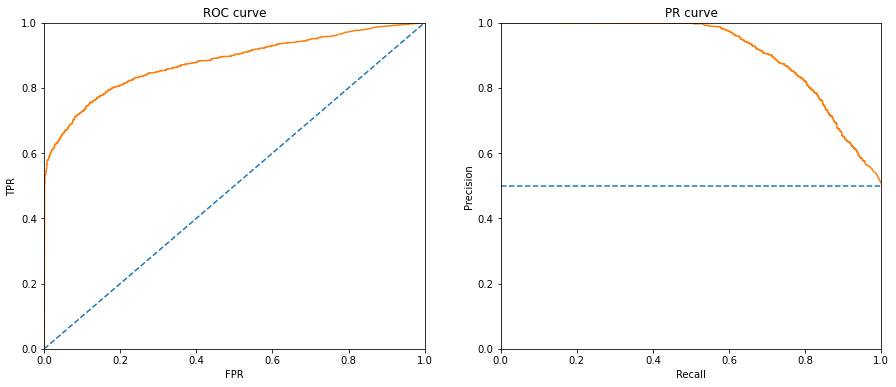

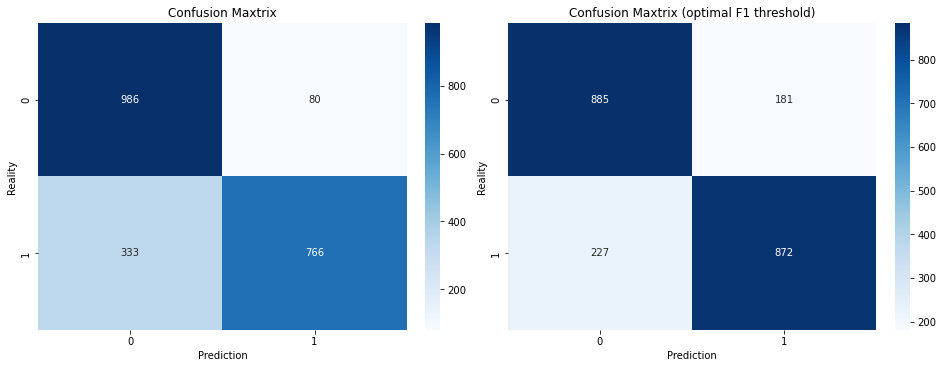

In [30]:
best_threshold = visualize_tests(probabilities1[:, 1], target_valid)

### Timeshifted set

Processing validation set, please wait warmly...
F1: 0.78 (max: 0.81 at 0.33 threshold), ROC_AUC: 0.878, accuracy: 80%, AP (PR_AUC): 0.91


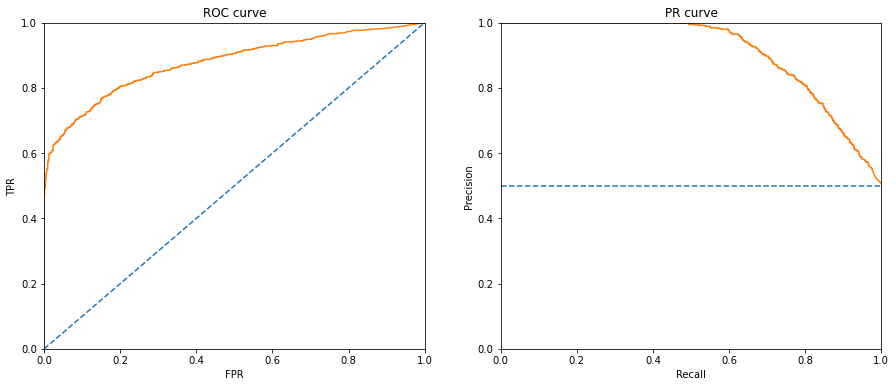

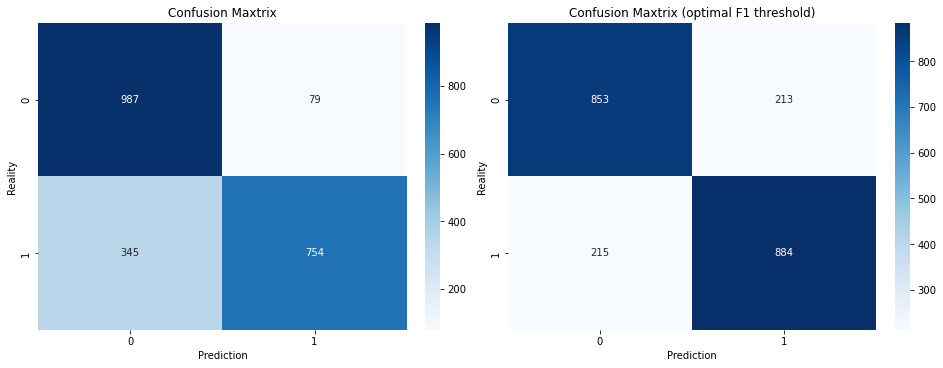

In [31]:
best_threshold = visualize_tests(probabilities2[:, 1], target_valid)

### Swapped channels set

Processing validation set, please wait warmly...
F1: 0.78 (max: 0.80 at 0.38 threshold), ROC_AUC: 0.878, accuracy: 81%, AP (PR_AUC): 0.91


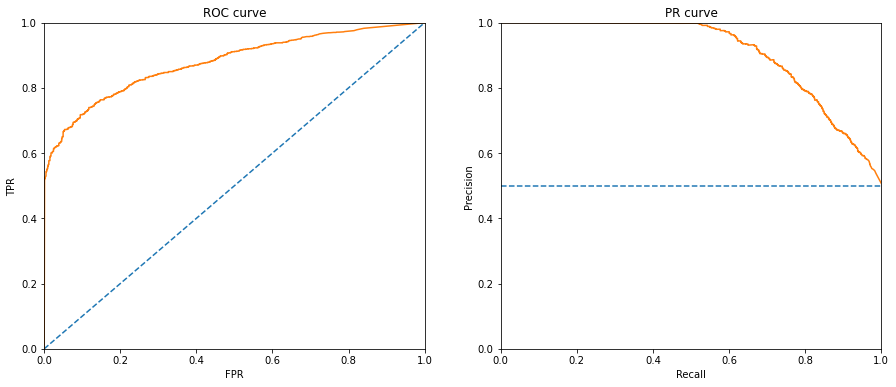

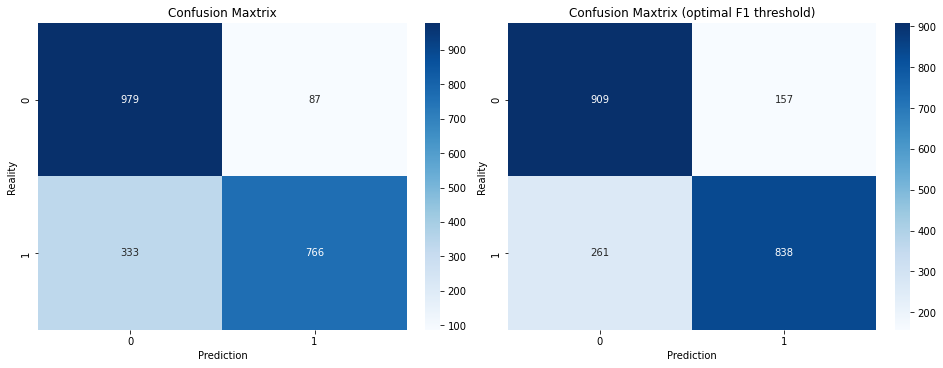

In [32]:
best_threshold = visualize_tests(probabilities3[:, 1], target_valid)

Overall, all three models provide similar results: around 80% accuracy translates into 87-88% ROC-AUC score. Default precision is very acceptable (only around 10% detections are false), recall however looks significatly worse (just about 70% GW signals are correctly recognized). Threshold ajustment might improve the situation a bit: near 85% precision and 75% recall can be achieved at an ideal F1 threshold, further recall improvement is possible with a larger $\beta$.

## Ensembling

We'll be using a simple logistic regression meta model to blend our results together. Other metamodels like MultinomialNB and Gaussian Process can be used but yield no benefit over this one:

In [33]:
def fit_ensemble():
    meta_X = list()
    meta_X.append(probabilities1)
    meta_X.append(probabilities2)
    meta_X.append(probabilities3)
    meta_X = np.hstack(meta_X)
    blender = LogisticRegression()
    blender.fit(meta_X, target_valid)
    return blender

def predict_ensemble(blender, features):
    meta_X = list()
    meta_X.append(net1.predict_proba(features))
    meta_X.append(net2.predict_proba(features))
    meta_X.append(net3.predict_proba(features))
    meta_X = np.hstack(meta_X)
    return blender.predict_proba(meta_X)

In [34]:
blender = fit_ensemble()

In [35]:
probabilities = predict_ensemble(blender, valid_set)[:, 1]

Processing validation set, please wait warmly...
F1: 0.80 (max: 0.81 at 0.31 threshold), ROC_AUC: 0.882, accuracy: 81%, AP (PR_AUC): 0.91


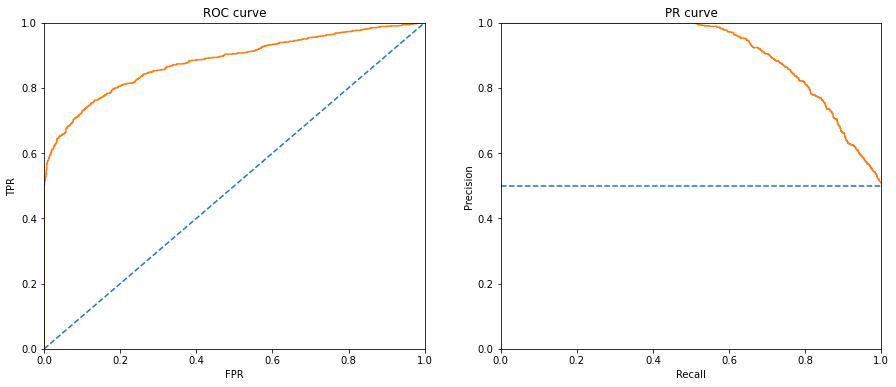

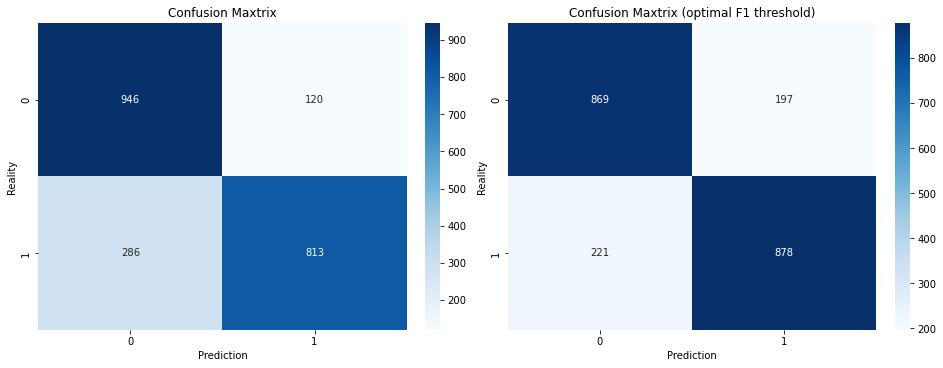

In [36]:
best_threshold = visualize_tests(probabilities, target_valid)

The ensemble improves the prediction variance, however the boost is not significant: around 0.1-0.2% metrics improvement.

## Testing and sample submission

In [37]:
test_set = NPYHotSwap('/media/data/g2net-gravitational-wave-detection/test/', labels)

In [38]:
predictions = predict_ensemble(blender, test_set)

In [39]:
test_results = pd.DataFrame(data = {'id': test_set.files, 'target': predictions[:,1]}).set_index('id')

In [40]:
test_results.head()

,target
id,
00005bced6,0.938168
0000806717,0.938168
0000ef4fe1,0.227676
00020de251,0.938165
00024887b5,0.190534


In [41]:
test_results.to_csv('sample_submission.csv')

This implementation yileds 0.875 ROC-AUC score on Kaggle private test.